### Import Statements

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

## 1. Data Preparation:

### Load the Kuzushiji dataset

In [ ]:
# Load the KMNIST dataset
kmnist_data = tfds.load('kmnist', split=['train', 'test'], as_supervised=True)

# Split the data into training and testing sets
train_data, test_data = kmnist_data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.LN7U7I_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.LN7U7I_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


image size: (28, 28, 1)


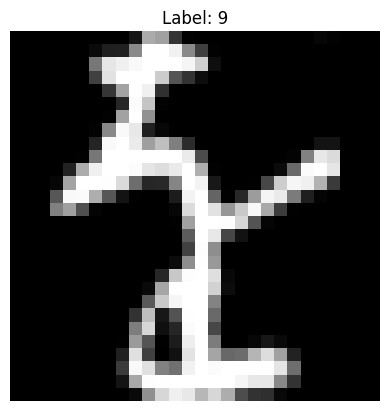

In [ ]:
# Get one example from the training dataset
ex_img, ex_lbl = next(iter(train_data))

# Display the image
print(f"image size: {ex_img.shape}")
plt.imshow(ex_img.numpy().squeeze(), cmap='gray')
plt.title(f'Label: {ex_lbl.numpy()}')
plt.axis('off')
plt.show()

### Preprocess the data by normalizing the pixel values between 0 and 1.

In [ ]:
# Preprocess the data: Normalize the pixel values between 0 and 1
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

train_data = train_data.map(normalize)
test_data = test_data.map(normalize)

From the above image pixel values, we can see that the image has been normalized from 0-255 to 0-1

### Split the dataset into training (80%) and testing (20%) sets.

In [ ]:
# Split dataset into training (80%) and testing (20%)
train_size = int(0.8 * tf.data.experimental.cardinality(train_data).numpy())
test_size = tf.data.experimental.cardinality(test_data).numpy()

train_split = train_data.take(train_size)
test_split = train_data.skip(train_size)

print(f"Training samples: {train_size}, Testing samples: {test_size}")

Training samples: 48000, Testing samples: 10000


## Radial Basis Function (RBF) Network:

### Implement an RBF network using a Gaussian basis function.

In [ ]:
class RBFNetwork:
    def __init__(self, num_centers, num_classes, sigma):
        self.num_centers = num_centers
        self.num_classes = num_classes
        self.sigma = sigma
        self.centers = None
        self.weights = None

    def _gaussian_rbf(self, X):
        diff = X[:, np.newaxis, :] - self.centers[np.newaxis, :, :]
        return np.exp(-np.sum(diff**2, axis=2) / (2 * self.sigma**2))

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_centers)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        RBF_output = self._gaussian_rbf(X)
        self.weights = np.linalg.pinv(RBF_output).dot(y)

    def predict(self, X):
        RBF_output = self._gaussian_rbf(X)
        output = RBF_output.dot(self.weights)
        return np.argmax(output, axis=1)

In [ ]:
# defining the Parameters
num_centers = 64
num_classes = 10
sigma = 1.0

In [ ]:
# Prepare data for fitting
x_train_batches = []
y_train_batches = []

for images, labels in train_split.batch(32):  # Process in batches
    x_train_batches.append(images.numpy().reshape(-1, 784))
    y_train_batches.append(tf.one_hot(labels, depth=num_classes).numpy())

x_train_np = np.concatenate(x_train_batches)
y_train_np = np.concatenate(y_train_batches)

# Create and train the RBF network
rbf_network = RBFNetwork(num_centers, num_classes, sigma)
rbf_network.fit(x_train_np, y_train_np)


## Training:

In [ ]:
def train_rbf_network(rbf_network, x_train, y_train, learning_rate=0.01, epochs=10):
    for epoch in range(epochs):
        RBF_output = rbf_network._gaussian_rbf(x_train)
        predictions = RBF_output.dot(rbf_network.weights)

        # Calculate the error
        error = y_train - predictions

        # Update weights using gradient descent
        rbf_network.weights += learning_rate * (RBF_output.T.dot(error))

# Train the RBF network
train_rbf_network(rbf_network, x_train_np, y_train_np)

## Evaluation

Test Accuracy: 77.85%
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      1178
           1       0.74      0.74      0.74      1236
           2       0.68      0.71      0.69      1172
           3       0.79      0.83      0.81      1255
           4       0.52      0.87      0.65      1143
           5       0.99      0.74      0.85      1219
           6       0.73      0.76      0.74      1231
           7       0.93      0.87      0.90      1237
           8       0.82      0.68      0.75      1168
           9       0.93      0.77      0.84      1161

    accuracy                           0.78     12000
   macro avg       0.81      0.78      0.78     12000
weighted avg       0.81      0.78      0.79     12000



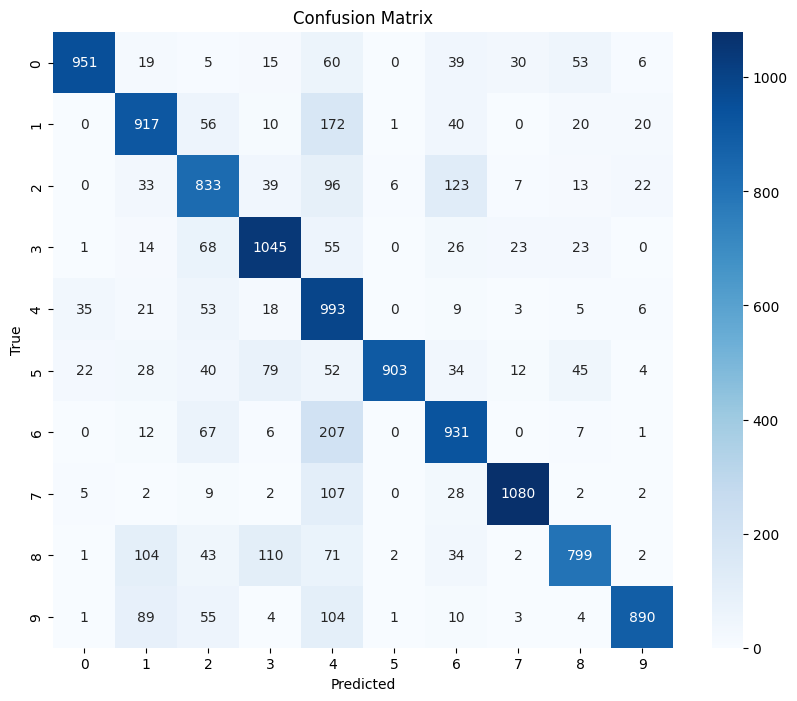

In [ ]:
# Prepare test data
x_test_np = np.array([x.numpy().flatten() for x, _ in test_split])
y_test_np = np.array([y.numpy() for _, y in test_split])

# Make predictions
predictions = rbf_network.predict(x_test_np)

# Calculate accuracy
accuracy = accuracy_score(y_test_np, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
report = classification_report(y_test_np, predictions)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_np, predictions)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Step 5: Analysis  
#### Strengths and Limitations of RBF Networks:
- Strengths:
  - Good for interpolation in high-dimensional spaces.
  - Simple and interpretable.
- Limitations:
  - Sensitive to the choice of centers and spread (sigma).
  - May require a large number of centers for complex datasets.

#### Effect of Number of RBF Units:
Increasing the number of RBF units generally improves the model's ability to capture complexity but can lead to overfitting if too many units are used. A lower number of RBF units may result in underfitting, failing to capture the underlying data distribution.
